In [8]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

In [64]:
def graph(Adress, fromdate):

    sample_transport = RequestsHTTPTransport(
        url='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3',
        verify=True,
        retries=5,
    )
    client = Client(
        transport=sample_transport
    )
    
    print(datetime.utcfromtimestamp(fromdate).strftime('%Y-%m-%d %H:%M:%S'))
    
    query = gql(
        '''
        query ($fromdate: Int!){
            poolHourDatas(
                where: {pool: "''' + str(Adress) + '''", periodStartUnix_gt: $fromdate},
                orderBy: periodStartUnix,
                orderDirection: desc,
                first: 1000
            ) {
                periodStartUnix
                liquidity
                high
                low
                pool {
                    totalValueLockedUSD
                    totalValueLockedToken1
                    totalValueLockedToken0
                    token0 {
                        decimals
                    }
                    token1 {
                        decimals
                    }
                }
                close
                feeGrowthGlobal0X128
                feeGrowthGlobal1X128
            }
        }
        '''
    )

    params = {
        "fromdate": fromdate
    }

    response = client.execute(query, variable_values=params)
    dpd = pd.json_normalize(response['poolHourDatas'])
    dpd = dpd.astype(float)
    return dpd

In [61]:
def get_amount0(sqrtA, sqrtB, liquidity, decimals):
    if sqrtA > sqrtB:
        (sqrtA, sqrtB) = (sqrtB, sqrtA)

    amount0 = ((liquidity * 2 ** 96 * (sqrtB - sqrtA) / sqrtB / sqrtA) / 10 ** decimals)

    return amount0


def get_amount1(sqrtA, sqrtB, liquidity, decimals):
    if sqrtA > sqrtB:
        (sqrtA, sqrtB) = (sqrtB, sqrtA)

    amount1 = liquidity * (sqrtB - sqrtA) / 2 ** 96 / 10 ** decimals

    return amount1


def get_amounts(asqrt, asqrtA, asqrtB, liquidity, decimal0, decimal1):
    sqrt = (np.sqrt(asqrt * 10 ** (decimal1 - decimal0))) * (2 ** 96)
    sqrtA = np.sqrt(asqrtA * 10 ** (decimal1 - decimal0)) * (2 ** 96)
    sqrtB = np.sqrt(asqrtB * 10 ** (decimal1 - decimal0)) * (2 ** 96)

    if sqrtA > sqrtB:
        (sqrtA, sqrtB) = (sqrtB, sqrtA)

    if sqrt <= sqrtA:

        amount0 = get_amount0(sqrtA, sqrtB, liquidity, decimal0)
        return amount0, 0

    elif sqrtB > sqrt > sqrtA:
        amount0 = get_amount0(sqrt, sqrtB, liquidity, decimal0)

        amount1 = get_amount1(sqrtA, sqrt, liquidity, decimal1)

        return amount0, amount1

    else:
        amount1 = get_amount1(sqrtA, sqrtB, liquidity, decimal1)
        return 0, amount1


'''get_liquidity function'''


# Use 'get_liquidity' function to calculate liquidity as a function of amounts and price range
def get_liquidity0(sqrtA, sqrtB, amount0, decimals):
    if sqrtA > sqrtB:
        (sqrtA, sqrtB) = (sqrtB, sqrtA)

    liquidity = amount0 / ((2 ** 96 * (sqrtB - sqrtA) / sqrtB / sqrtA) / 10 ** decimals)
    return liquidity


def get_liquidity1(sqrtA, sqrtB, amount1, decimals):
    if sqrtA > sqrtB:
        (sqrtA, sqrtB) = (sqrtB, sqrtA)

    liquidity = amount1 / ((sqrtB - sqrtA) / 2 ** 96 / 10 ** decimals)
    return liquidity


def get_liquidity(asqrt, asqrtA, asqrtB, amount0, amount1, decimal0, decimal1):
    sqrt = (np.sqrt(asqrt * 10 ** (decimal1 - decimal0))) * (2 ** 96)
    sqrtA = np.sqrt(asqrtA * 10 ** (decimal1 - decimal0)) * (2 ** 96)
    sqrtB = np.sqrt(asqrtB * 10 ** (decimal1 - decimal0)) * (2 ** 96)

    if sqrtA > sqrtB:
        (sqrtA, sqrtB) = (sqrtB, sqrtA)

    if sqrt <= sqrtA:

        liquidity0 = get_liquidity0(sqrtA, sqrtB, amount0, decimal0)
        return liquidity0

    elif sqrtB > sqrt > sqrtA:

        liquidity0 = get_liquidity0(sqrt, sqrtB, amount0, decimal0)
        liquidity1 = get_liquidity1(sqrtA, sqrt, amount1, decimal1)
        liquidity = liquidity0 if liquidity0 < liquidity1 else liquidity1
        return liquidity

    else:
        liquidity1 = get_liquidity1(sqrtA, sqrtB, amount1, decimal1)
        return liquidity1


In [65]:
Adress = "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"  # ETH USDC Ethereum
# Adress = "0x2e9c575206288f2219409289035facac0b670c2f"  # ETH DAI Optimism
# Adress= "0x68f180fcce6836688e9084f035309e29bf0a2095" #  WBTC DAI
# Adress = "0x93f267fd92b432bebf4da4e13b8615bb8eb2095c"  # snx eth
# Adress = "0xcb0c5d9d92f4f2f80cce7aa271a1e148c226e19d"  # Rai Dai

startfrom = 1632081600

In [66]:
dpd = graph(Adress, startfrom)
dpd.head()

2021-09-19 20:00:00


,periodStartUnix,liquidity,high,low,close,feeGrowthGlobal0X128,feeGrowthGlobal1X128,pool.totalValueLockedUSD,pool.totalValueLockedToken1,pool.totalValueLockedToken0,pool.token0.decimals,pool.token1.decimals
0,1.704510e+09,5.612741e+18,2259.164351,2259.164351,2259.164351,3.268831e+33,1.537222e+42,2.911258e+08,65390.904664,1.433970e+08,6.0,18.0
1,1.704506e+09,5.612741e+18,2262.423515,2259.994934,2259.994934,3.268831e+33,1.537218e+42,2.911258e+08,65390.904664,1.433970e+08,6.0,18.0
2,1.704503e+09,5.808530e+18,2266.155391,2262.455372,2262.455372,3.268831e+33,1.537204e+42,2.911258e+08,65390.904664,1.433970e+08,6.0,18.0
3,1.704499e+09,5.808530e+18,2268.567638,2266.809772,2266.809772,3.268831e+33,1.537185e+42,2.911258e+08,65390.904664,1.433970e+08,6.0,18.0
4,1.704496e+09,5.808530e+18,2270.876095,2245.287691,2268.882536,3.268831e+33,1.537176e+42,2.911258e+08,65390.904664,1.433970e+08,6.0,18.0


<AxesSubplot:xlabel='periodStartUnix', ylabel='close'>

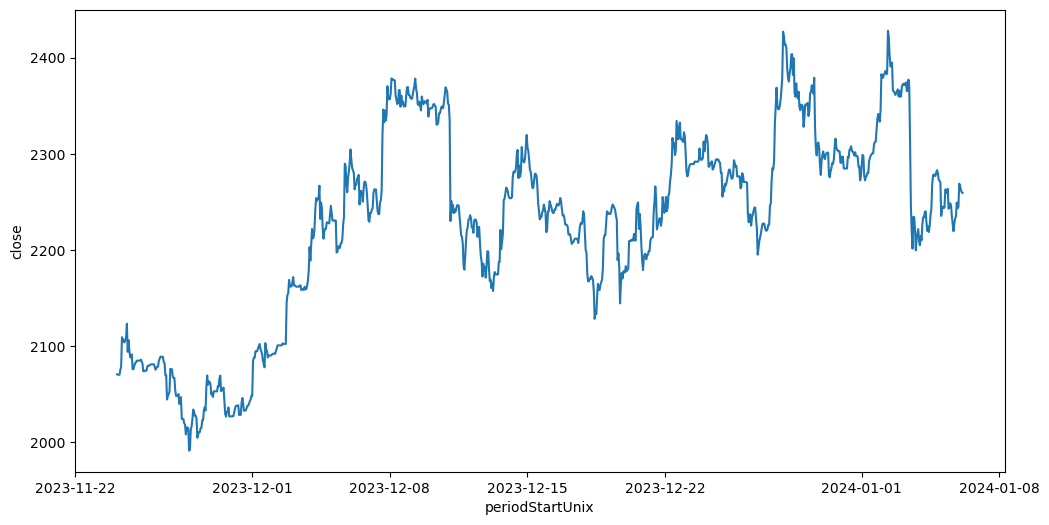

In [67]:
import seaborn as sns

f = plt.figure(figsize=(12,6))
sns.lineplot(x=pd.to_datetime(dpd.periodStartUnix, unit='s'), y=dpd.close)

In [68]:
print(datetime.utcfromtimestamp(
    dpd.periodStartUnix.min()
).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.utcfromtimestamp(
    dpd.periodStartUnix.max()
).strftime('%Y-%m-%d %H:%M:%S'))

2023-11-24 03:00:00
2024-01-06 03:00:00


In [69]:
decimal0 = dpd.iloc[0]['pool.token0.decimals']
decimal1 = dpd.iloc[0]['pool.token1.decimals']
decimal = decimal1 - decimal0
print(decimal0, decimal1, decimal)

6.0 18.0 12.0


In [70]:
dpd['fg0'] = ((dpd['feeGrowthGlobal0X128']) / (2 ** 128)) / (10 ** decimal0)
dpd['fg1'] = ((dpd['feeGrowthGlobal1X128']) / (2 ** 128)) / (10 ** decimal1)

In [71]:
print(dpd['close'].iloc[-1])

2070.3381501463145


In [90]:
mini = 1982.32
maxi = 2519.99
target = dpd['close'].iloc[-1]  # the initial price
# target = 2711.53
base = 0

Calculate F0G and F1G (fee earned by an unbounded unit of liquidity in one period):

In [91]:
dpd['fg0shift'] = dpd['fg0'].shift(-1)
dpd['fg1shift'] = dpd['fg1'].shift(-1)
dpd['fee0token'] = dpd['fg0'] - dpd['fg0shift']
dpd['fee1token'] = dpd['fg1'] - dpd['fg1shift']

Calculate my liquidity:

In [92]:
SMIN = np.sqrt(mini * 10 ** decimal)
SMAX = np.sqrt(maxi * 10 ** decimal)
print(SMIN, SMAX)

44523252.35200142 50199501.98956161


In [93]:
print(datetime.utcfromtimestamp(
    dpd.periodStartUnix.iloc[-1]
).strftime('%Y-%m-%d %H:%M:%S'))

2023-11-24 03:00:00


In [94]:
dpd['close'].iloc[-1]

2070.3381501463145

In [95]:
if base == 0:

    sqrt0 = np.sqrt(dpd['close'].iloc[-1] * 10 ** decimal)
    dpd['price0'] = dpd['close']

else:

    sqrt0 = np.sqrt(1 / dpd['close'].iloc[-1] * 10 ** decimal)
    dpd['price0'] = 1 / dpd['close']


if SMIN < sqrt0 < SMAX:

    deltaL = target / ((sqrt0 - SMIN) + (((1 / sqrt0) - (1 / SMAX)) * (dpd['price0'].iloc[-1] * 10 ** decimal)))
    amount1 = deltaL * (sqrt0 - SMIN)
    amount0 = deltaL * ((1 / sqrt0) - (1 / SMAX)) * 10 ** decimal

elif sqrt0 < SMIN:

    deltaL = target / (((1 / SMIN) - (1 / SMAX)) * (dpd['price0'].iloc[-1]))
    amount1 = 0
    amount0 = deltaL * ((1 / SMIN) - (1 / SMAX))

else:
    deltaL = target / (SMAX - SMIN)
    amount1 = deltaL * (SMAX - SMIN)
    amount0 = 0
    
print("Amounts:", amount0, amount1)

Amounts: 0.8132874917570267 386.5580289249359


In [96]:
# print(dpd['price0'].iloc[-1],mini,maxi)
# print((dpd['price0'].iloc[-1],mini,maxi,amount0,amount1,decimal0,decimal1))
myliquidity = get_liquidity(dpd['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1)

print("OK myliquidity", myliquidity)

OK myliquidity 395368289119124.56


In [97]:
# Calculate ActiveLiq

dpd['ActiveLiq'] = 0
dpd['amount0'] = 0
dpd['amount1'] = 0
dpd['amount0unb'] = 0
dpd['amount1unb'] = 0

if base == 0:
    
    for i, row in dpd.iterrows():
        if dpd['high'].iloc[i] > mini and dpd['low'].iloc[i] < maxi:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = (min(maxi, dpd['high'].iloc[i]) - max(dpd['low'].iloc[i],
                                                                                                  mini)) / (
                                                                        dpd['high'].iloc[i] - dpd['low'].iloc[i]) * 100
        else:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = 0

        amounts = get_amounts(dpd['price0'].iloc[i], mini, maxi, myliquidity, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0')] = amounts[1]
        dpd.iloc[i, dpd.columns.get_loc('amount1')] = amounts[0]

        amountsunb = get_amounts((dpd['price0'].iloc[i]), 1.0001 ** (-887220), 1.0001 ** 887220, 1, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0unb')] = amountsunb[1]
        dpd.iloc[i, dpd.columns.get_loc('amount1unb')] = amountsunb[0]
        
else:
    
    for i, row in dpd.iterrows():

        if (1 / dpd['low'].iloc[i]) > mini and (1 / dpd['high'].iloc[i]) < maxi:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = (min(maxi, 1 / dpd['low'].iloc[i]) - max(
                1 / dpd['high'].iloc[i], mini)) / ((1 / dpd['low'].iloc[i]) - (1 / dpd['high'].iloc[i])) * 100
        else:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = 0

        amounts = get_amounts((dpd['price0'].iloc[i] * 10 ** (decimal)), mini, maxi, myliquidity, decimal0,
                                        decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0')] = amounts[0]
        dpd.iloc[i, dpd.columns.get_loc('amount1')] = amounts[1]

        amountsunb = get_amounts((dpd['price0'].iloc[i]), 1.0001 ** (-887220), 1.0001 ** 887220, 1, decimal0,
                                           decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0unb')] = amountsunb[0]
        dpd.iloc[i, dpd.columns.get_loc('amount1unb')] = amountsunb[1]

/var/folders/s0/gcg7k5ws6hxfgnzww6_ryn0c0000gn/T/ipykernel_5606/1794527647.py:13: RuntimeWarning: invalid value encountered in double_scalars
  dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = (min(maxi, dpd['high'].iloc[i]) - max(dpd['low'].iloc[i],


In [98]:
## Final fee calculation

dpd['myfee0'] = dpd['fee0token'] * myliquidity * dpd['ActiveLiq'] / 100
dpd['myfee1'] = dpd['fee1token'] * myliquidity * dpd['ActiveLiq'] / 100

print(dpd['myfee0'].sum())
print(dpd['myfee1'].sum())

68.88208485441228
0.029557374773843494


In [99]:
if base == 0:
    
    dpd['feeV'] = (dpd['myfee0']) + (dpd['myfee1'] * dpd['close'])
    dpd['amountV'] = (dpd['amount0']) + (dpd['amount1'] * dpd['close'])
    dpd['amountunb'] = (dpd['amount0unb']) + (dpd['amount1unb'] * dpd['close'])
    dpd['fgV'] = (dpd['fee0token']) + (dpd['fee1token'] * dpd['close'])
    dpd['feeusd'] = dpd['feeV'] * (dpd['pool.totalValueLockedUSD'].iloc[0] / (
                dpd['pool.totalValueLockedToken1'].iloc[0] * dpd['close'].iloc[0] + (
        dpd['pool.totalValueLockedToken0'].iloc[0])))

else:

    dpd['feeV'] = (dpd['myfee0'] / dpd['close']) + dpd['myfee1']
    dpd['amountV'] = (dpd['amount0'] / dpd['close']) + dpd['amount1']
    dpd['feeVbase0'] = dpd['myfee0'] + (dpd['myfee1'] * dpd['close'])
    dpd['amountunb'] = (dpd['amount0unb'] / dpd['close']) + dpd['amount1unb']
    dpd['fgV'] = (dpd['fee0token'] / dpd['close']) + dpd['fee1token']
    dpd['feeusd'] = dpd['feeV'] * (dpd['pool.totalValueLockedUSD'].iloc[0] / (
                dpd['pool.totalValueLockedToken1'].iloc[0] + (
                    dpd['pool.totalValueLockedToken0'].iloc[0] / dpd['close'].iloc[0])))

dpd['date'] = pd.to_datetime(dpd['periodStartUnix'], unit='s')

### 1 Chart

In [102]:
# dpd['fgV']= (dpd['fg0'] / dpd['close'].iloc[0] + dpd['fg1'])
# rint(dpd['fg1']/dpd['amount1unb'])

data = dpd[['date', 'myfee0', 'myfee1', 'fgV', 'feeV', 'feeusd', 'amountV', 'ActiveLiq', 'amountunb', 'amount0', 'amount1', 'close']]
data = data.fillna(0)

temp = data.resample('D', on='date').sum()
final1 = temp[['myfee0', 'myfee1', 'feeV', 'fgV', 'feeusd']].copy()

temp2 = data.resample('D', on='date').mean()
final1['ActiveLiq'] = temp2['ActiveLiq'].copy()

temp3 = data.resample('D', on='date').first()
final1[['amountV', 'amountunb']] = temp3[['amountV', 'amountunb']].copy()
temp4 = data.resample('D', on='date').last()
final1[['amountVlast']] = temp4[['amountV']]

final1['S1%'] = final1['feeV'] / final1['amountV'] * 100  # *365
final1['unb%'] = final1['fgV'] / final1['amountunb'] * 100  # *365
final1['multiplier'] = final1['S1%'] / final1['unb%']
final1['feeunb'] = final1['amountV'] * final1['unb%'] / 100
final1.to_csv("chart1.csv", sep=";")

print("this position returned", final1['feeV'].sum() / final1['amountV'].iloc[0] * 100, "in ", len(final1.index),
      " days, for an apr of ", final1['feeV'].sum() / final1['amountV'].iloc[0] * 365 / len(final1.index) * 100)
print("a base  position returned", final1['feeunb'].sum() / final1['amountV'].iloc[0] * 100, "in ",
      len(final1.index), " days, for an apr of ",
      final1['feeunb'].sum() / final1['amountV'].iloc[0] * 365 / len(final1.index) * 100)

print("fee in token 1 and token 2", dpd['myfee0'].sum(), dpd['myfee1'].sum())
print("totalFee in USD", final1['feeusd'].sum())
print('Your liquidity was active for:', final1['ActiveLiq'].mean())
# forecast = (dpd['feeVbase0'].sum() * myliquidity * final1['ActiveLiq'].mean())
# print(dpd['feeVbase0'])
# print('forecast: ', forecast)

this position returned 6.5249532060763284 in  44  days, for an apr of  54.12745273222409
a base  position returned 0.3790500914747632 in  44  days, for an apr of  3.1443928042792857
fee in token 1 and token 2 68.88208485441228 0.029557374773843494
totalFee in USD 135.0885955045933
Your liquidity was active for: 93.1732921055784


In [103]:
final1[['feeunb', 'feeV', 'feeusd', 'amountV', 'ActiveLiq', 'S1%', 'unb%', 'ActiveLiq']]

,feeunb,feeV,feeusd,amountV,ActiveLiq,S1%,unb%,ActiveLiq
date,,,,,,,,
2023-11-24,0.137603,2.388345,2.388345,2070.338150,90.000000,0.115360,0.006646,90.000000
2023-11-25,0.022362,0.387929,0.387929,2077.105715,94.736842,0.018676,0.001077,94.736842
2023-11-26,0.083796,1.454033,1.454033,2078.668723,100.000000,0.069950,0.004031,100.000000
2023-11-27,0.127535,2.206475,2.206475,2067.219239,86.956522,0.106736,0.006169,86.956522
2023-11-28,0.111319,1.945180,1.945180,2039.034269,91.666667,0.095397,0.005459,91.666667
2023-11-29,0.074607,1.300603,1.300603,2050.530989,81.818182,0.063428,0.003638,81.818182
2023-11-30,0.051991,0.910429,0.910429,2032.813157,91.666667,0.044787,0.002558,91.666667
2023-12-01,0.099627,1.736299,1.736299,2051.552934,90.476190,0.084633,0.004856,90.476190
2023-12-02,0.132076,2.264739,2.264739,2087.231694,76.190476,0.108504,0.006328,76.190476


<AxesSubplot:xlabel='date', ylabel='feeusd'>

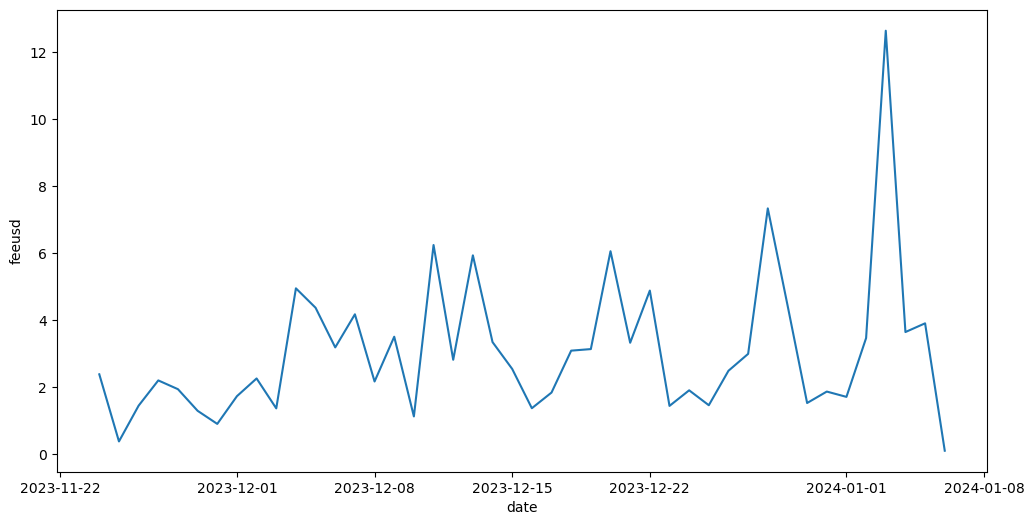

In [106]:
f = plt.figure(figsize=(12,6))
sns.lineplot(x=final1.index, y=final1.feeusd)

## 2 chart

In [111]:
final2 = temp3[['amountV', 'amount0', 'amount1', 'close']].copy()
final2['feeV'] = temp['feeV'].copy()
final2[['amountVlast']] = temp4[['amountV']]

final2['HODL'] = final2['amount0'].iloc[0] + final2['amount1'].iloc[0] * final2['close']

final2['IL'] = final2['amountVlast'] - final2['HODL']
final2['ActiveLiq'] = temp2['ActiveLiq'].copy()
final2['feecumsum'] = final2['feeV'].cumsum()
final2['PNL'] = final2['feecumsum'] + final2['IL']  # -Bfinal['gas']

final2['HODLnorm'] = final2['HODL'] / final2['amountV'].iloc[0] * 100
final2['ILnorm'] = final2['IL'] / final2['amountV'].iloc[0] * 100
final2['PNLnorm'] = final2['PNL'] / final2['amountV'].iloc[0] * 100
final2['feecumsumnorm'] = final2['feecumsum'] / final2['amountV'].iloc[0] * 100
ch2 = final2[['amountV', 'feecumsum']]
ch3 = final2[['ILnorm', 'PNLnorm', 'feecumsumnorm']]

final2.to_csv("chart2.csv", sep=";")

In [112]:
final2

,amountV,amount0,amount1,close,feeV,amountVlast,HODL,IL,ActiveLiq,feecumsum,PNL,HODLnorm,ILnorm,PNLnorm,feecumsumnorm
date,,,,,,,,,,,,,,,
2023-11-24,2070.338150,386.558029,0.813287,2070.338150,2.388345,2074.661300,2070.338150,4.323150,90.000000,2.388345,6.711496,100.000000,0.208814,0.324174,0.115360
2023-11-25,2077.105715,423.069439,0.795688,2078.750511,0.387929,2078.744126,2077.179818,1.564307,94.736842,2.776274,4.340582,100.330461,0.075558,0.209656,0.134098
2023-11-26,2078.668723,431.606496,0.791583,2080.719940,1.454033,2068.337979,2078.781530,-10.443552,100.000000,4.230307,-6.213245,100.407826,-0.504437,-0.300108,0.204329
2023-11-27,2067.219239,369.970738,0.821307,2066.522013,2.206475,2029.945625,2067.234533,-37.288908,86.956522,6.436782,-30.852126,99.850091,-1.801102,-1.490197,0.310905
2023-11-28,2039.034269,226.248557,0.891415,2033.604117,1.945180,2054.225875,2040.462820,13.763055,91.666667,8.381962,22.145016,98.556983,0.664773,1.069633,0.404860
2023-11-29,2050.530989,283.600522,0.863304,2046.708229,1.300603,2032.766732,2051.120231,-18.353499,81.818182,9.682565,-8.670934,99.071750,-0.886498,-0.418817,0.467680
2023-11-30,2032.813157,195.883696,0.906372,2026.683215,0.910429,2051.568891,2034.834137,16.734754,91.666667,10.592993,27.327747,98.285110,0.808310,1.319965,0.511655
2023-12-01,2051.552934,288.779950,0.860774,2047.893727,1.736299,2085.835607,2052.084381,33.751226,90.476190,12.329292,46.080517,99.118319,1.630228,2.225748,0.595521
2023-12-02,2087.231694,479.109550,0.768813,2091.695536,2.264739,2136.023356,2087.707845,48.315511,76.190476,14.594031,62.909543,100.838979,2.333701,3.038612,0.704911


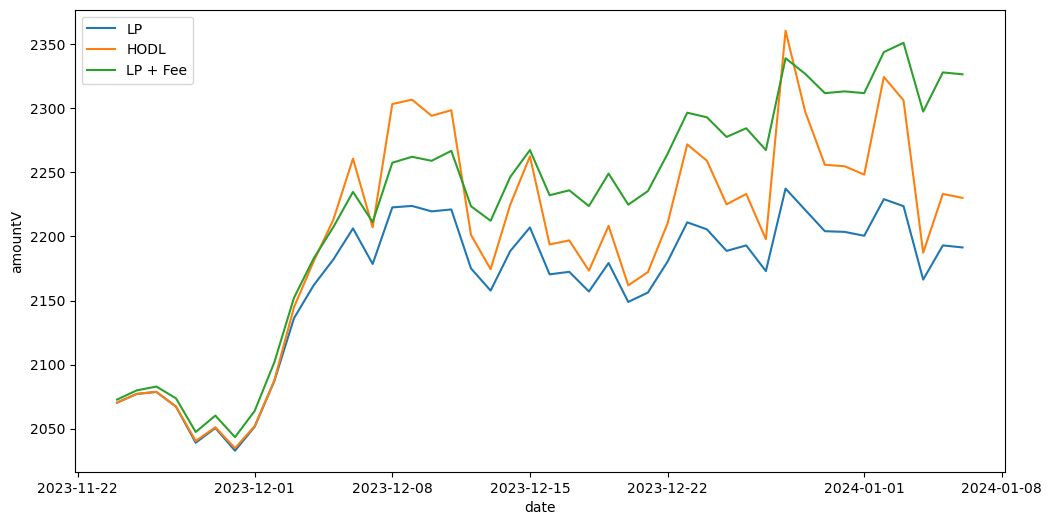

In [118]:
f2 = plt.figure(figsize=(12,6))
sns.lineplot(x=final2.index, y=final2.amountV, label='LP')
sns.lineplot(x=final2.index, y=final2.HODL, label='HODL')
sns.lineplot(x=final2.index, y=final2.amountV + final2.feecumsum, label='LP + Fee')
plt.legend()

In [ ]:
# final3=data
final3 = pd.DataFrame()
final3['amountV'] = data['amountV']

final3['amountVlast'] = data['amountV'].shift(-1)
final3['date'] = data['date']
final3['HODL'] = data['amount0'].iloc[0] / data['close'] + data['amount1'].iloc[0]

final3['amountVlast'].iloc[-1] = final3['HODL'].iloc[-1]
final3['IL'] = final3['amountVlast'] - final3['HODL']
final3['feecumsum'] = data['feeV'][::-1].cumsum()
final3['PNL'] = final3['feecumsum'] + final3['IL']
final3['HODLnorm'] = final3['HODL'] / final3['amountV'].iloc[0] * 100
final3['ILnorm'] = final3['IL'] / final3['amountV'].iloc[0] * 100
final3['PNLnorm'] = final3['PNL'] / final3['amountV'].iloc[0] * 100
final3['feecumsumnorm'] = final3['feecumsum'] / final3['amountV'].iloc[0] * 100

ch2 = final3[['amountV', 'feecumsum']]
ch3 = final3[['ILnorm', 'PNLnorm', 'feecumsumnorm']]

In [84]:
def chart1(dpd, base, myliquidity):
    if base == 0:
        dpd['feeV'] = (dpd['myfee0']) + (dpd['myfee1'] * dpd['close'])
        dpd['amountV'] = (dpd['amount0']) + (dpd['amount1'] * dpd['close'])
        dpd['amountunb'] = (dpd['amount0unb']) + (dpd['amount1unb'] * dpd['close'])
        dpd['fgV'] = (dpd['fee0token']) + (dpd['fee1token'] * dpd['close'])
        dpd['feeusd'] = dpd['feeV'] * (dpd['pool.totalValueLockedUSD'].iloc[0] / (
                    dpd['pool.totalValueLockedToken1'].iloc[0] * dpd['close'].iloc[0] + (
            dpd['pool.totalValueLockedToken0'].iloc[0])))

    else:

        dpd['feeV'] = (dpd['myfee0'] / dpd['close']) + dpd['myfee1']
        dpd['amountV'] = (dpd['amount0'] / dpd['close']) + dpd['amount1']
        dpd['feeVbase0'] = dpd['myfee0'] + (dpd['myfee1'] * dpd['close'])
        dpd['amountunb'] = (dpd['amount0unb'] / dpd['close']) + dpd['amount1unb']
        dpd['fgV'] = (dpd['fee0token'] / dpd['close']) + dpd['fee1token']
        dpd['feeusd'] = dpd['feeV'] * (dpd['pool.totalValueLockedUSD'].iloc[0] / (
                    dpd['pool.totalValueLockedToken1'].iloc[0] + (
                        dpd['pool.totalValueLockedToken0'].iloc[0] / dpd['close'].iloc[0])))

    dpd['date'] = pd.to_datetime(dpd['periodStartUnix'], unit='s')

    # 1 Chart

    # dpd['fgV']= (dpd['fg0'] / dpd['close'].iloc[0] + dpd['fg1'])
    # rint(dpd['fg1']/dpd['amount1unb'])

    data = dpd[
        ['date', 'myfee0', 'myfee1', 'fgV', 'feeV', 'feeusd', 'amountV', 'ActiveLiq', 'amountunb', 'amount0', 'amount1',
         'close']]
    data = data.fillna(0)

    temp = data.resample('D', on='date').sum()
    final1 = temp[['myfee0', 'myfee1', 'feeV', 'fgV', 'feeusd']].copy()

    temp2 = data.resample('D', on='date').mean()
    final1['ActiveLiq'] = temp2['ActiveLiq'].copy()

    temp3 = data.resample('D', on='date').first()
    final1[['amountV', 'amountunb']] = temp3[['amountV', 'amountunb']].copy()
    temp4 = data.resample('D', on='date').last()
    final1[['amountVlast']] = temp4[['amountV']]

    final1['S1%'] = final1['feeV'] / final1['amountV'] * 100  # *365
    final1['unb%'] = final1['fgV'] / final1['amountunb'] * 100  # *365
    final1['multiplier'] = final1['S1%'] / final1['unb%']
    final1['feeunb'] = final1['amountV'] * final1['unb%'] / 100
    final1.to_csv("chart1.csv", sep=";")

    print(final1[['feeunb', 'feeV', 'feeusd', 'amountV', 'ActiveLiq', 'S1%', 'unb%', 'ActiveLiq']])

    print('------------------------------------------------------------------')
    print("this position returned", final1['feeV'].sum() / final1['amountV'].iloc[0] * 100, "in ", len(final1.index),
          " days, for an apr of ", final1['feeV'].sum() / final1['amountV'].iloc[0] * 365 / len(final1.index) * 100)
    print("a base  position returned", final1['feeunb'].sum() / final1['amountV'].iloc[0] * 100, "in ",
          len(final1.index), " days, for an apr of ",
          final1['feeunb'].sum() / final1['amountV'].iloc[0] * 365 / len(final1.index) * 100)

    print("fee in token 1 and token 2", dpd['myfee0'].sum(), dpd['myfee1'].sum())
    print("totalFee in USD", final1['feeusd'].sum())
    print('Your liquidity was active for:', final1['ActiveLiq'].mean())
    forecast = (dpd['feeVbase0'].sum() * myliquidity * final1['ActiveLiq'].mean())
    print(dpd['feeVbase0'])
    print('forecast: ', forecast)
    print('------------------------------------------------------------------')
    # 1 chart e' completo

    # 2 chart

    final2 = temp3[['amountV', 'amount0', 'amount1', 'close']].copy()
    final2['feeV'] = temp['feeV'].copy()
    final2[['amountVlast']] = temp4[['amountV']]

    final2['HODL'] = final2['amount0'].iloc[0] / final2['close'] + final2['amount1'].iloc[0]

    final2['IL'] = final2['amountVlast'] - final2['HODL']
    final2['ActiveLiq'] = temp2['ActiveLiq'].copy()
    final2['feecumsum'] = final2['feeV'].cumsum()
    final2['PNL'] = final2['feecumsum'] + final2['IL']  # -Bfinal['gas']

    final2['HODLnorm'] = final2['HODL'] / final2['amountV'].iloc[0] * 100
    final2['ILnorm'] = final2['IL'] / final2['amountV'].iloc[0] * 100
    final2['PNLnorm'] = final2['PNL'] / final2['amountV'].iloc[0] * 100
    final2['feecumsumnorm'] = final2['feecumsum'] / final2['amountV'].iloc[0] * 100
    ch2 = final2[['amountV', 'feecumsum']]
    ch3 = final2[['ILnorm', 'PNLnorm', 'feecumsumnorm']]

    final2.to_csv("chart2.csv", sep=";")
    print(ch2)
    print(ch3)

    # final3=data
    final3 = pd.DataFrame()
    final3['amountV'] = data['amountV']

    final3['amountVlast'] = data['amountV'].shift(-1)
    final3['date'] = data['date']
    final3['HODL'] = data['amount0'].iloc[0] / data['close'] + data['amount1'].iloc[0]

    final3['amountVlast'].iloc[-1] = final3['HODL'].iloc[-1]
    final3['IL'] = final3['amountVlast'] - final3['HODL']
    final3['feecumsum'] = data['feeV'][::-1].cumsum()
    final3['PNL'] = final3['feecumsum'] + final3['IL']
    final3['HODLnorm'] = final3['HODL'] / final3['amountV'].iloc[0] * 100
    final3['ILnorm'] = final3['IL'] / final3['amountV'].iloc[0] * 100
    final3['PNLnorm'] = final3['PNL'] / final3['amountV'].iloc[0] * 100
    final3['feecumsumnorm'] = final3['feecumsum'] / final3['amountV'].iloc[0] * 100

    ch2 = final3[['amountV', 'feecumsum']]
    ch3 = final3[['ILnorm', 'PNLnorm', 'feecumsumnorm']]

    print(ch2)
    print(ch3)


In [83]:
a = chart1(dpd, base, myliquidity)

NameError: name 'chart1' is not defined

In [ ]:
# '''
# query ($fromdate: Int!){
#   poolHourDatas(
#     where: {pool: "''' + str(Adress) + '''",, periodStartUnix_gt: $fromdate},
#     orderBy: periodStartUnix,
#     orderDirection: desc,
#     first: 1000
#   ) {
#     periodStartUnix
#     liquidity
#     low
#     pool {
#       totalValueLockedUSD
#       totalValueLockedToken1
#       totalValueLockedToken0
#       token0 {
#         decimals
#       }
#       token1 {
#         decimals
#       }
#     }
#     close
#     feeGrowthGlobal0X128
#     feeGrowthGlobal1X128
#   }
# }
# '''